In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import func_plot as fp
import seaborn as sns
import nibabel as nib
from scipy.stats import norm
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

# Parcelwise PLS chapman with age and gender regression

In [35]:
"""
Partial Least Squares (PLS) pipeline for cortical gradient–behavior relationships
(including healthy controls).

This version:
1. Loads gradient CSVs (one per gradient).
2. Includes all subjects (no diagnosis filtering).
3. Encodes gender (and diagnosis if needed) numerically.
4. Z-scores cognitive variables before averaging into domains.
5. Inverts cognitive domain scores (higher = worse performance).
6. Regresses out age and gender from brain features (X).
7. Z-scores both X and Y before PLS.
8. Fits PLS and extracts saliences, scores, and behavior–LV correlations.
9. Stores results in a dictionary and prints summaries.
"""

import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ---------------------------------------------------
# SETTINGS
# ---------------------------------------------------
parcel_cols = [f'node_{i+1}' for i in range(400)]

# Clinical variables (chap version)
clinical_vars = [
    'Hypomanic_scale',
    'Perceptual_aberration_scale',
    'Physical_anhedonia_scale',
    'Social_anhedonia_scale',
    'Hopkins_depression_scale'
]

# Cognitive domain definitions
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Covariates to regress out from brain data
covariate_cols = ['age', 'gender']

# Gradient files
gradient_files = {
    'G1': './g1_aligned_chap.csv',
    'G2': './g2_aligned_chap.csv',
    'G3': './g3_aligned_chap.csv'
}

# Initialize results dictionary
results = {}

# ---------------------------------------------------
# HELPER FUNCTIONS
# ---------------------------------------------------
def regress_out(X, covariates):
    """
    Regress out age/gender from each brain feature (column of X).
    X: n × p matrix (subjects × parcels)
    covariates: n × k matrix (e.g., age, gender)
    """
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        model = LinearRegression().fit(covariates, X[:, j])
        X_resid[:, j] = X[:, j] - model.predict(covariates)
    return X_resid


def ensure_numeric_encoding(df, col):
    """Ensure categorical columns (e.g., gender or diagnosis) are numeric."""
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df


# ---------------------------------------------------
# MAIN LOOP OVER GRADIENTS
# ---------------------------------------------------
for grad_name, file_path in gradient_files.items():
    print(f"\n=== Processing {grad_name} ===")

    # Load gradient file
    df = pd.read_csv(file_path)

    # Encode gender numerically (and diagnosis if present)
    for col in ['gender', 'diagnosis']:
        if col in df.columns:
            df = ensure_numeric_encoding(df, col)

    # -------------------------------
    # Create cognitive domain scores
    # -------------------------------
    for group_name, var_list in group_definitions.items():
        missing = [v for v in var_list if v not in df.columns]
        if missing:
            raise KeyError(f"Missing cognitive variables for domain '{group_name}': {missing}")
        # Z-score each variable, then average, invert so higher = worse
        zscored = df[var_list].apply(lambda col: (col - col.mean()) / col.std(ddof=0), axis=0)
        df[group_name] = -zscored.mean(axis=1)

    # -------------------------------
    # Extract imaging (X) and behavioral (Y)
    # -------------------------------
    X = df[parcel_cols].values
    Y_cols = clinical_vars + list(group_definitions.keys())
    Y = df[Y_cols].values

    # Remove subjects with missing data
    nan_rows_X = np.isnan(X).any(axis=1)
    nan_rows_Y = np.isnan(Y).any(axis=1)
    valid = ~(nan_rows_X | nan_rows_Y)
    X_valid = X[valid]
    Y_valid = Y[valid]
    df_valid = df.loc[valid].copy()

    # -------------------------------
    # Regress out age and gender from X
    # -------------------------------
    covars = df_valid[covariate_cols].values
    X_resid = regress_out(X_valid, covars)

    # -------------------------------
    # Standardize X and Y
    # -------------------------------
    X_std = StandardScaler().fit_transform(X_resid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # -------------------------------
    # Fit PLS (1 component)
    # -------------------------------
    pls = PLSRegression(n_components=1)
    pls.fit(X_std, Y_std)

    # Extract scores and saliences
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    X_saliences = pls.x_weights_[:, 0]
    Y_saliences = pls.y_weights_[:, 0]

    # -------------------------------
    # Compute behavioral correlations
    # -------------------------------
    behav_corrs = {}
    for i, var in enumerate(Y_cols):
        r, _ = pearsonr(Y_std[:, i], Y_scores)
        behav_corrs[var] = r

    # -------------------------------
    # Save results
    # -------------------------------
    results[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid,
        'df_valid': df_valid,
        'X_std': X_std,
        'Y_std': Y_std
    }

    # -------------------------------
    # Print summary
    # -------------------------------
    print(f"{grad_name} behavioral correlations (higher = worse):")
    for var, corr in behav_corrs.items():
        print(f"  {var:30s}: {corr:6.3f}")

print("\nAll gradients processed. Results stored in `results` dict.")



=== Processing G1 ===
G1 behavioral correlations (higher = worse):
  Hypomanic_scale               :  0.258
  Perceptual_aberration_scale   :  0.710
  Physical_anhedonia_scale      :  0.581
  Social_anhedonia_scale        :  0.601
  Hopkins_depression_scale      :  0.527
  Attention_WorkingMemory       :  0.647
  VerbalLearning_Memory         :  0.685
  Reasoning_ProblemSolving      :  0.607
  Verbal_Comprehension          :  0.608

=== Processing G2 ===
G2 behavioral correlations (higher = worse):
  Hypomanic_scale               :  0.303
  Perceptual_aberration_scale   :  0.728
  Physical_anhedonia_scale      :  0.546
  Social_anhedonia_scale        :  0.589
  Hopkins_depression_scale      :  0.512
  Attention_WorkingMemory       :  0.657
  VerbalLearning_Memory         :  0.658
  Reasoning_ProblemSolving      :  0.616
  Verbal_Comprehension          :  0.646

=== Processing G3 ===
G3 behavioral correlations (higher = worse):
  Hypomanic_scale               :  0.454
  Perceptual_aber

## Cortical projection

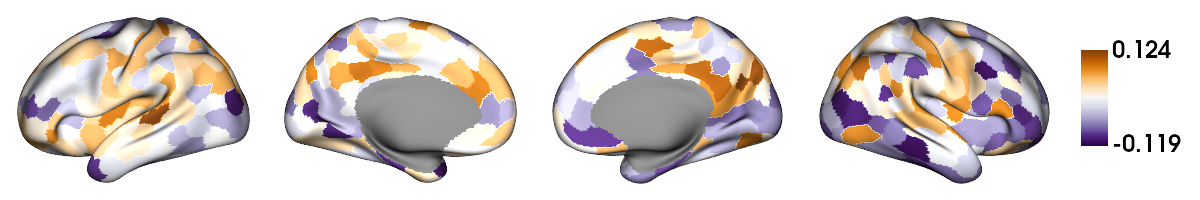

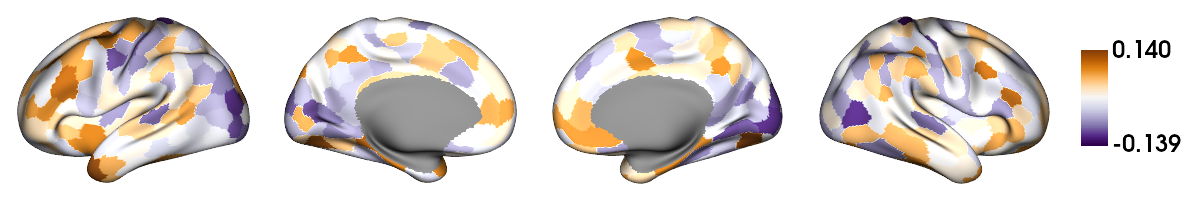

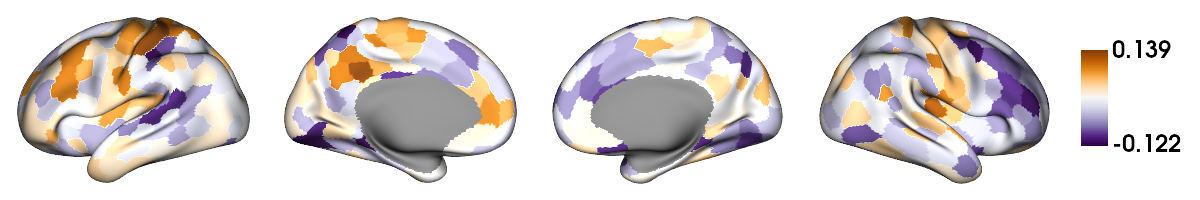

✅ Gradient LV1 cortical maps (including controls) saved to 'new_figures/'


In [36]:
from IPython.display import Image, display
import numpy as np
import os

# Ensure output folder exists
os.makedirs("new_figures", exist_ok=True)

# Loop through all gradients in the new PLS results (including controls)
for grad_name, res in results.items():
    X_saliences = res['X_saliences']  # LV1 saliences only

    # Create brain map: NaN everywhere except labeled parcels
    brain_map = np.full_like(atlas, np.nan, dtype=float)
    for j in range(len(X_saliences)):
        brain_map[atlas == j + 1] = X_saliences[j]
    brain_map[atlas == 0] = np.nan  # mask background / non-cortex

    # Define output filename (includes gradient name)
    filename = f'./new_figures/{grad_name}_LV1_map_cortex_chap.png'

    # Plot cortical surface (using your custom plotting function)
    fp.plot_surface(
        data=[brain_map],
        size=(1200, 200),
        cmap='PuOr_r',
        display=False,  # Save instead of showing interactively
        filename=filename
    )

    # Display saved image inline (optional)
    display(Image(filename))

print("✅ Gradient LV1 cortical maps (including controls) saved to 'new_figures/'")


## Permutation testing

In [37]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000  # number of permutations
n_components = 1         # LV1 only
results_perm = {}        # store permutation results

# Loop through all gradients (G1, G2, G3)
for grad_name, res in results.items():
    print(f"\nPermutation testing for {grad_name}...")

    # Retrieve standardized X and Y (from new analysis)
    X = res['X_std']  # standardized brain data (residualized + z-scored)
    Y = res['Y_std']  # standardized behavioral data

    # -------------------------------
    # Observed PLS (non-permuted)
    # -------------------------------
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)

    # Compute observed LV1 covariance (singular value)
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    obs_singular_value = np.cov(X_scores, Y_scores, bias=True)[0, 1]

    # -------------------------------
    # Permutation null distribution
    # -------------------------------
    perm_singular_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        # Shuffle rows of X (break brain–behavior correspondence)
        X_perm = X[np.random.permutation(X.shape[0]), :]

        pls_perm = PLSRegression(n_components=n_components)
        pls_perm.fit(X_perm, Y)

        X_scores_perm = pls_perm.x_scores_[:, 0]
        Y_scores_perm = pls_perm.y_scores_[:, 0]

        # Compute covariance for LV1
        perm_singular_values[i] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # Compute one-tailed p-value (proportion of permuted >= observed)
    p_value = np.mean(perm_singular_values >= obs_singular_value)

    # Store results
    results_perm[grad_name] = {
        'obs_singular_value': obs_singular_value,
        'perm_singular_values': perm_singular_values,
        'p_value': p_value
    }

    print(f"{grad_name} LV1 permutation p-value: {p_value:.4f}")

print("\n✅ Permutation testing complete. Results stored in `results_perm`.")



Permutation testing for G1...
G1 LV1 permutation p-value: 0.2480

Permutation testing for G2...
G2 LV1 permutation p-value: 0.5434

Permutation testing for G3...
G3 LV1 permutation p-value: 0.5420

✅ Permutation testing complete. Results stored in `results_perm`.


## Bootstrap resampling


Bootstrap resampling for G1...


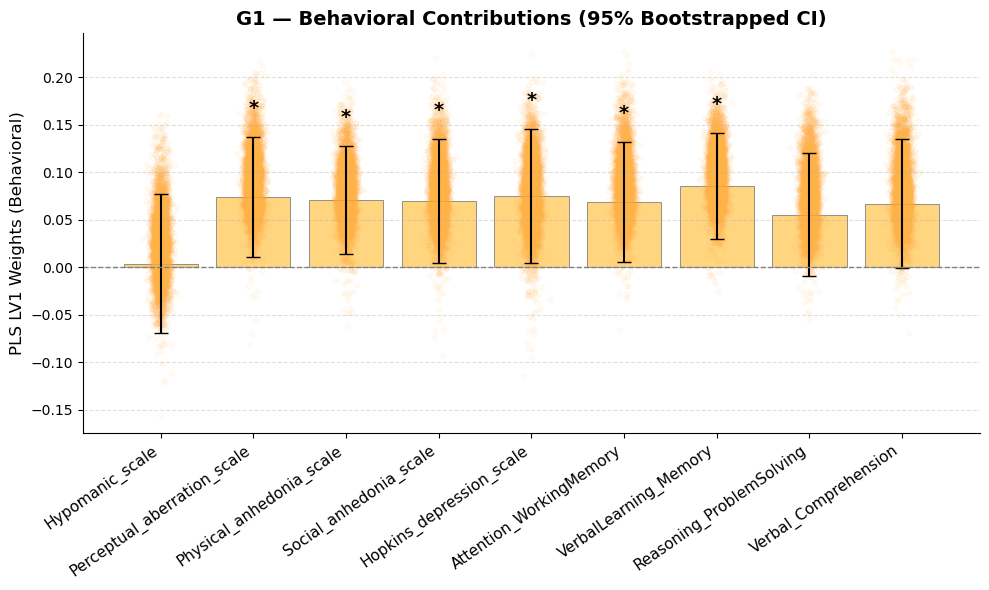


Bootstrap resampling for G2...


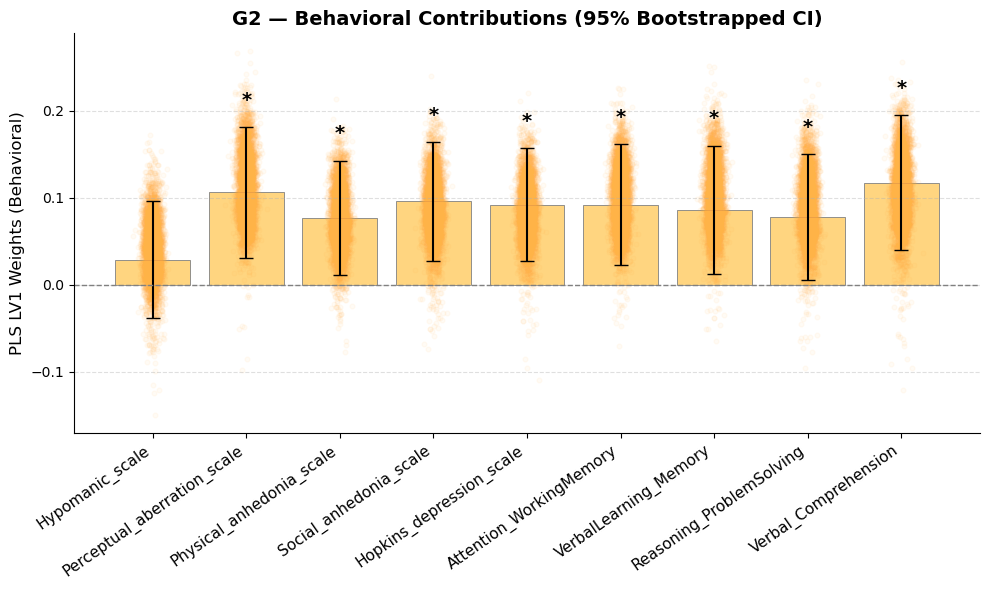


Bootstrap resampling for G3...


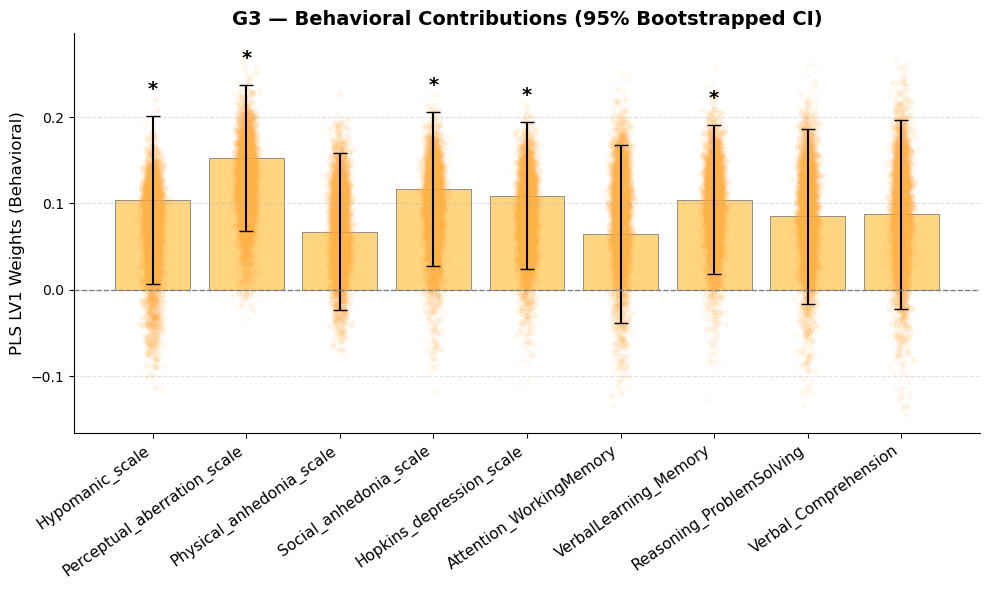


✅ Bootstrap resampling complete. Results stored in `results_boot`.


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap = 5000   # number of bootstrap resamples
n_components = 1      # LV1 only
results_boot = {}     # store bootstrap outputs

# Colors for plotting
bar_color = '#FFD580'
point_color = '#FFB347'
star_color = 'black'

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results.items():
    print(f"\nBootstrap resampling for {grad_name}...")

    # Standardized data from new analysis (residualized, z-scored)
    X = res['X_std']
    Y = res['Y_std']
    n_subjects, n_voxels = X.shape
    n_behav = Y.shape[1]

    # ----------------------------------
    # Original PLS to get LV1 loadings
    # ----------------------------------
    pls_orig = PLSRegression(n_components=n_components)
    pls_orig.fit(X, Y)
    X_orig_weights = pls_orig.x_weights_[:, 0]
    Y_orig_weights = pls_orig.y_weights_[:, 0]

    # ----------------------------------
    # Bootstrap resampling
    # ----------------------------------
    X_boot_weights = np.zeros((n_bootstrap, n_voxels))
    Y_boot_weights = np.zeros((n_bootstrap, n_behav))

    for i in range(n_bootstrap):
        # Resample subjects with replacement
        Xb, Yb = resample(X, Y, n_samples=n_subjects, replace=True)

        pls_boot = PLSRegression(n_components=n_components)
        pls_boot.fit(Xb, Yb)
        Xb_weights = pls_boot.x_weights_[:, 0]
        Yb_weights = pls_boot.y_weights_[:, 0]

        # Align LV sign with original LV1
        if np.dot(Xb_weights, X_orig_weights) < 0:
            Xb_weights *= -1
            Yb_weights *= -1

        X_boot_weights[i, :] = Xb_weights
        Y_boot_weights[i, :] = Yb_weights

    # ----------------------------------
    # Compute bootstrap ratios (BSRs)
    # ----------------------------------
    X_bsr = X_orig_weights / X_boot_weights.std(axis=0)
    Y_bsr = Y_orig_weights / Y_boot_weights.std(axis=0)

    results_boot[grad_name] = {
        'X_bsr': X_bsr,
        'Y_bsr': Y_bsr,
        'X_boot_weights': X_boot_weights,
        'Y_boot_weights': Y_boot_weights
    }

    # ----------------------------------
    # Behavioral contribution plot
    # ----------------------------------
    Y_cols = list(res['behav_corrs'].keys())

    y_mean = Y_orig_weights
    y_sd = Y_boot_weights.std(axis=0)
    lower_ci = y_mean - 1.96 * y_sd
    upper_ci = y_mean + 1.96 * y_sd

    # Determine significance (95% CI excluding zero)
    significant = (lower_ci > 0) | (upper_ci < 0)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bars with 95% CI
    bars = ax.bar(np.arange(n_behav), y_mean,
                  width=0.8,
                  yerr=[y_mean - lower_ci, upper_ci - y_mean],
                  capsize=5, color=bar_color, edgecolor='gray', linewidth=0.6)

    # Overlay bootstrap points
    for j in range(n_behav):
        x_jitter = np.random.normal(j, 0.05, size=n_bootstrap)
        ax.scatter(x_jitter, Y_boot_weights[:, j],
                   color=point_color, alpha=0.05, s=12)

    # Zero reference line
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Add significance stars
    for j, sig in enumerate(significant):
        if sig:
            ax.text(j, upper_ci[j] + 0.02, "*", ha='center', va='bottom',
                    fontsize=14, color=star_color, fontweight='bold')

    # Formatting
    ax.set_xticks(np.arange(n_behav))
    ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=11)
    ax.set_ylabel('PLS LV1 Weights (Behavioral)', fontsize=12)
    ax.set_title(f'{grad_name} — Behavioral Contributions (95% Bootstrapped CI)',
                 fontsize=14, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.show()

print("\n✅ Bootstrap resampling complete. Results stored in `results_boot`.")


## Variance explained


Computing variance explained for G1...
  LV1 explains 7.07% of X variance, 6.45% of Y variance, and 5.67% shared variance.

Computing variance explained for G2...
  LV1 explains 5.58% of X variance, 7.87% of Y variance, and 2.73% shared variance.

Computing variance explained for G3...
  LV1 explains 4.36% of X variance, 9.06% of Y variance, and 2.08% shared variance.


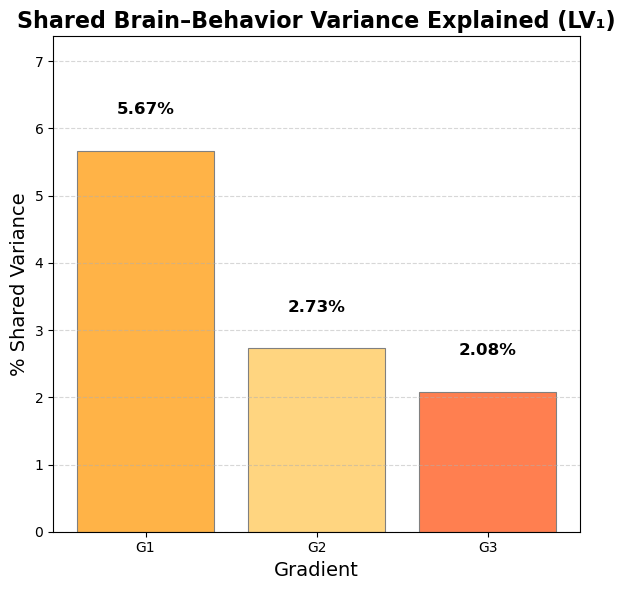


✅ Variance explained analysis complete. Results stored in `var_explained_dict`.


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

# -------------------------------------
# Create output folder if not exists
# -------------------------------------
os.makedirs("new_figures", exist_ok=True)

# -------------------------------------
# Variance explained dictionary
# -------------------------------------
var_explained_dict = {}

for grad_name, res in results.items():
    print(f"\nComputing variance explained for {grad_name}...")

    X = res['X_std']  # standardized (residualized) brain data
    Y = res['Y_std']  # standardized behavioral/clinical data

    pls = PLSRegression(n_components=1)
    pls.fit(X, Y)

    # ----------------------------
    # Reconstruct predicted X and Y
    # ----------------------------
    X_pred = pls.x_scores_ @ pls.x_loadings_.T
    Y_pred = pls.x_scores_ @ pls.y_loadings_.T

    # ----------------------------
    # Compute variance explained
    # ----------------------------
    var_X_total = np.var(X, axis=0).sum()
    var_Y_total = np.var(Y, axis=0).sum()

    var_X_expl = np.var(X_pred, axis=0).sum() / var_X_total
    var_Y_expl = np.var(Y_pred, axis=0).sum() / var_Y_total

    # Shared cross-covariance variance (singular value-based)
    shared_var = (pls.x_scores_.T @ pls.y_scores_)**2 / (np.sum(X**2) * np.sum(Y**2))
    shared_var = shared_var.item()

    # Store results in both the master dict and inside the results
    res['var_X_expl'] = var_X_expl
    res['var_Y_expl'] = var_Y_expl
    res['shared_var'] = shared_var

    var_explained_dict[grad_name] = {
        'X_var%': var_X_expl * 100,
        'Y_var%': var_Y_expl * 100,
        'Shared%': shared_var * 100
    }

    print(f"  LV1 explains {var_X_expl * 100:.2f}% of X variance, "
          f"{var_Y_expl * 100:.2f}% of Y variance, "
          f"and {shared_var * 100:.2f}% shared variance.")

# -------------------------------------
# Plot shared variance explained
# -------------------------------------
grad_names = list(var_explained_dict.keys())
shared_vals = [v['Shared%'] for v in var_explained_dict.values()]

plt.figure(figsize=(6, 6))
bars = plt.bar(grad_names, shared_vals,
               color=['#FFB347', '#FFD580', '#FF7F50'],
               edgecolor='gray', linewidth=0.8)

# Annotate each bar
for i, v in enumerate(shared_vals):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom',
             fontsize=12, fontweight='bold')

plt.title("Shared Brain–Behavior Variance Explained (LV₁)",
          fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.xlabel("Gradient", fontsize=14)
plt.ylim(0, max(shared_vals) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1.png", dpi=300)
plt.show()

print("\n✅ Variance explained analysis complete. Results stored in `var_explained_dict`.")


## New variance explained

Computing variance explained for CHAP-based PLS across all gradients...

G1:
  LV1 explains 7.07% of X variance, 6.45% of Y variance, 84.72% of total X–Y cross-covariance energy, and latent t–u r² = 18.96%

G2:
  LV1 explains 5.58% of X variance, 7.87% of Y variance, 88.00% of total X–Y cross-covariance energy, and latent t–u r² = 22.76%

G3:
  LV1 explains 4.36% of X variance, 9.06% of Y variance, 68.51% of total X–Y cross-covariance energy, and latent t–u r² = 26.95%



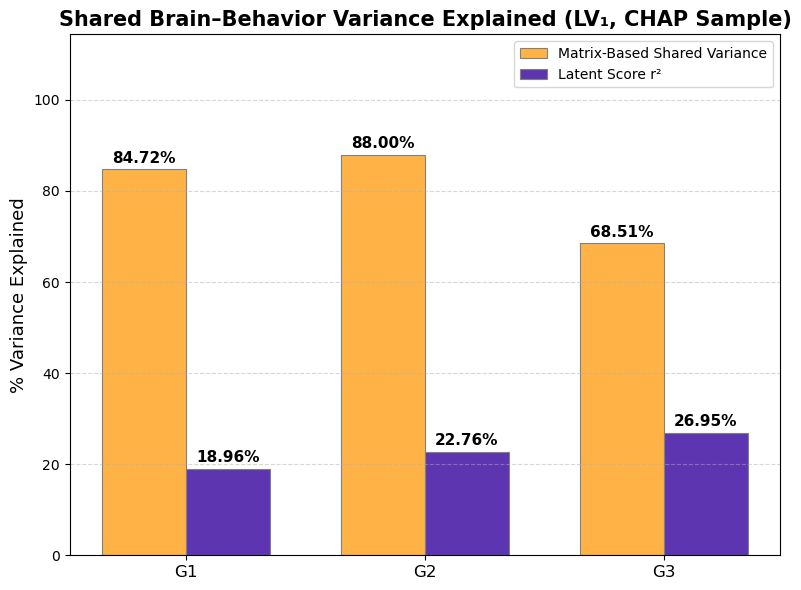


✅ CHAP variance explained analysis complete. Results stored in `var_explained_dict`.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

# -------------------------------------
# Create output folder if not exists
# -------------------------------------
os.makedirs("new_figures", exist_ok=True)

# -------------------------------------
# Initialize dictionary
# -------------------------------------
var_explained_dict = {}

print("Computing variance explained for CHAP-based PLS across all gradients...\n")

# -------------------------------------
# Loop through all gradient-based PLS
# -------------------------------------
for grad_name, res in results.items():

    X = res['X_std']  # standardized brain data
    Y = res['Y_std']  # standardized behavioral/clinical data
    n_samples = X.shape[0]

    pls = PLSRegression(n_components=1)
    pls.fit(X, Y)

    # Predicted data reconstruction
    X_pred = pls.x_scores_ @ pls.x_loadings_.T
    Y_pred = pls.x_scores_ @ pls.y_loadings_.T

    # Variance explained (block-specific)
    var_X_expl = np.sum(X_pred**2) / np.sum(X**2)
    var_Y_expl = np.sum(Y_pred**2) / np.sum(Y**2)

    # -------------------------------------
    # Shared variance (matrix-based approach)
    # -------------------------------------
    C_full = (X.T @ Y) / (n_samples - 1)
    C_pred = (X_pred.T @ Y_pred) / (n_samples - 1)

    total_cross_energy = np.sum(C_full**2)
    explained_cross_energy = np.sum(C_pred**2)
    shared_var_matrix = 0.0 if total_cross_energy == 0 else explained_cross_energy / total_cross_energy

    # -------------------------------------
    # Latent score correlation (r²)
    # -------------------------------------
    t = pls.x_scores_[:, 0]
    u = pls.y_scores_[:, 0]
    r2_latent = np.corrcoef(t, u)[0, 1] ** 2

    # -------------------------------------
    # Store results
    # -------------------------------------
    res['var_X_expl'] = var_X_expl
    res['var_Y_expl'] = var_Y_expl
    res['shared_var_matrix'] = shared_var_matrix
    res['r2_latent'] = r2_latent

    var_explained_dict[grad_name] = {
        'X_var%': var_X_expl * 100,
        'Y_var%': var_Y_expl * 100,
        'Shared_matrix%': shared_var_matrix * 100,
        'r2_latent%': r2_latent * 100
    }

    print(f"{grad_name}:")
    print(f"  LV1 explains {var_X_expl * 100:.2f}% of X variance, "
          f"{var_Y_expl * 100:.2f}% of Y variance, "
          f"{shared_var_matrix * 100:.2f}% of total X–Y cross-covariance energy, "
          f"and latent t–u r² = {r2_latent * 100:.2f}%\n")

# -------------------------------------
# Combined bar plot (Matrix vs Latent r²)
# -------------------------------------
grad_names = list(var_explained_dict.keys())
matrix_vals = [v['Shared_matrix%'] for v in var_explained_dict.values()]
latent_vals = [v['r2_latent%'] for v in var_explained_dict.values()]

x = np.arange(len(grad_names))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, matrix_vals, width,
        label='Matrix-Based Shared Variance',
        color='#FFB347', edgecolor='gray', linewidth=0.8)
plt.bar(x + width/2, latent_vals, width,
        label='Latent Score r²',
        color='#5E35B1', edgecolor='gray', linewidth=0.8)

# Annotate values
for i in range(len(grad_names)):
    plt.text(x[i] - width/2, matrix_vals[i] + 0.8, f"{matrix_vals[i]:.2f}%",
             ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x[i] + width/2, latent_vals[i] + 0.8, f"{latent_vals[i]:.2f}%",
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x, grad_names, fontsize=12)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared Brain–Behavior Variance Explained (LV₁, CHAP Sample)",
          fontsize=15, fontweight='bold')
plt.ylim(0, max(max(matrix_vals), max(latent_vals)) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_LV1.png", dpi=300)
plt.show()

print("\n✅ CHAP variance explained analysis complete. Results stored in `var_explained_dict`.")


## Cross validation

Running cross-validation + permutation testing for CHAP PLS results...


Cross-validating G1...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.050


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  → Cross-validated correlation p-value = 0.2970

Cross-validating G2...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.042
  → Cross-validated correlation p-value = 0.3000

Cross-validating G3...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.026
  → Cross-validated correlation p-value = 0.3750


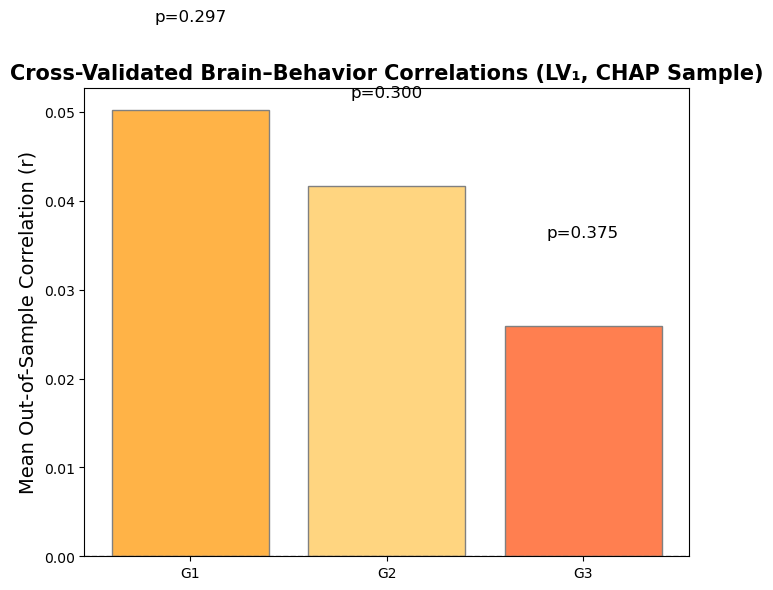


✅ CHAP cross-validation and permutation results stored in `cv_results`.


In [41]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, LeaveOneOut
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os

# --------------------------------------------------
# SETUP
# --------------------------------------------------
os.makedirs("new_figures", exist_ok=True)

n_splits = 5          # folds for larger samples
n_repeats = 20        # repeated KFold iterations
n_perm = 1000         # number of permutations
random_state = 42

cv_results = {}

print("Running cross-validation + permutation testing for CHAP PLS results...\n")

# --------------------------------------------------
# CROSS-VALIDATION PER GRADIENT
# --------------------------------------------------
for grad_name, res in results.items():
    print(f"\nCross-validating {grad_name}...")

    X = res["X_std"]
    Y = res["Y_std"]
    n = X.shape[0]

    # Choose appropriate CV strategy
    if n < 80:
        print(f"  Small sample detected (n={n}) → using Leave-One-Out CV.")
        use_loocv = True
        n_repeats_eff = 1
    else:
        print(f"  Using {n_splits}-fold CV with {n_repeats} repeats.")
        use_loocv = False
        n_repeats_eff = n_repeats

    # --------------------------------------------------
    # Cross-validation loop
    # --------------------------------------------------
    all_x_pred = np.zeros(n)
    all_y_pred = np.zeros(n)

    if use_loocv:
        loo = LeaveOneOut()
        for train_idx, test_idx in loo.split(X):
            pls = PLSRegression(n_components=1)
            pls.fit(X[train_idx], Y[train_idx])
            all_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
            all_y_pred[test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
    else:
        temp_x_pred = np.zeros((n_repeats_eff, n))
        temp_y_pred = np.zeros((n_repeats_eff, n))
        for rep in range(n_repeats_eff):
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
            for train_idx, test_idx in kf.split(X):
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y[train_idx])
                temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                temp_y_pred[rep, test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
        all_x_pred = temp_x_pred.mean(axis=0)
        all_y_pred = temp_y_pred.mean(axis=0)

    # --------------------------------------------------
    # Observed cross-validated correlation
    # --------------------------------------------------
    observed_r, _ = pearsonr(all_x_pred, all_y_pred)
    print(f"  Observed out-of-sample correlation: r = {observed_r:.3f}")

    # --------------------------------------------------
    # Permutation testing
    # --------------------------------------------------
    perm_corrs = np.zeros(n_perm)
    for perm in range(n_perm):
        Y_perm = Y[np.random.permutation(n)]

        if use_loocv:
            perm_x_pred = np.zeros(n)
            perm_y_pred = np.zeros(n)
            for test_idx in range(n):
                train_idx = np.setdiff1d(np.arange(n), test_idx)
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y_perm[train_idx])
                perm_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                perm_y_pred[test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
        else:
            temp_x_pred = np.zeros((n_repeats_eff, n))
            temp_y_pred = np.zeros((n_repeats_eff, n))
            for rep in range(n_repeats_eff):
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
                for train_idx, test_idx in kf.split(X):
                    pls = PLSRegression(n_components=1)
                    pls.fit(X[train_idx], Y_perm[train_idx])
                    temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                    temp_y_pred[rep, test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
            perm_x_pred = temp_x_pred.mean(axis=0)
            perm_y_pred = temp_y_pred.mean(axis=0)

        r_perm, _ = pearsonr(perm_x_pred, perm_y_pred)
        perm_corrs[perm] = r_perm

    pval = np.mean(perm_corrs >= observed_r)
    cv_results[grad_name] = {"observed_r": observed_r, "perm_corrs": perm_corrs, "pval": pval}

    print(f"  → Cross-validated correlation p-value = {pval:.4f}")

# --------------------------------------------------
# PLOT SUMMARY RESULTS
# --------------------------------------------------
plt.figure(figsize=(7, 6))
bars = plt.bar(
    cv_results.keys(),
    [cv_results[g]["observed_r"] for g in cv_results],
    color=["#FFB347", "#FFD580", "#FF7F50"],
    edgecolor="gray",
)
plt.ylabel("Mean Out-of-Sample Correlation (r)", fontsize=14)
plt.title("Cross-Validated Brain–Behavior Correlations (LV₁, CHAP Sample)",
          fontsize=15, fontweight="bold")

for i, g in enumerate(cv_results.keys()):
    r = cv_results[g]["observed_r"]
    p = cv_results[g]["pval"]
    plt.text(i, r + 0.01, f"p={p:.3f}", ha="center", fontsize=12)

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.tight_layout()
plt.savefig("new_figures/cv_out_of_sample_correlations.png", dpi=300)
plt.show()

print("\n✅ CHAP cross-validation and permutation results stored in `cv_results`.")


## Split half resampling

Running split-half stability analysis for CHAP PLS results...


Split-half resampling for G1...
  Brain pattern stability (mean r): 0.120
  Behavioral pattern stability (mean r): 0.100

Split-half resampling for G2...
  Brain pattern stability (mean r): 0.079
  Behavioral pattern stability (mean r): -0.021

Split-half resampling for G3...
  Brain pattern stability (mean r): 0.088
  Behavioral pattern stability (mean r): 0.008


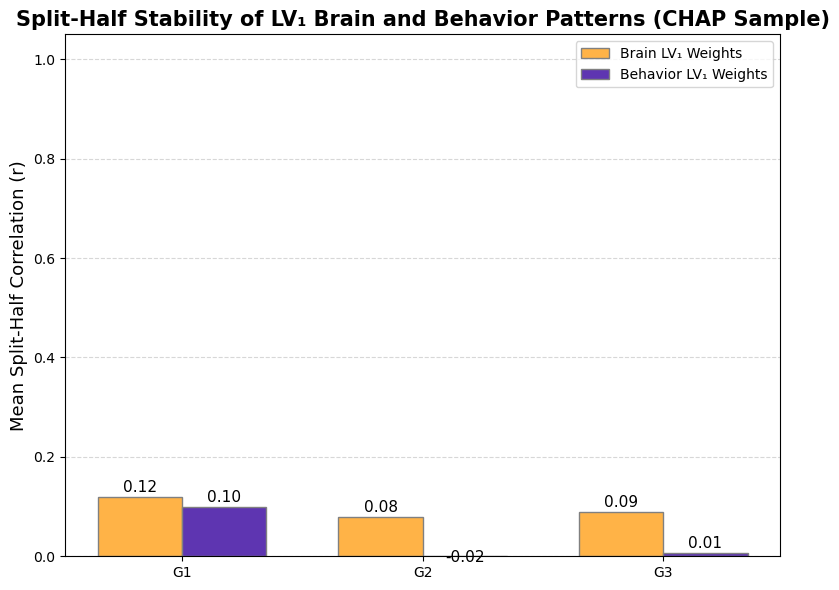


✅ Split-half stability results stored in `stability_results` and figure saved to new_figures/.


In [42]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import os

# --------------------------------------------------
# PARAMETERS
# --------------------------------------------------
n_splits = 100  # number of random split-half resamplings
random_state = 42
rng = np.random.default_rng(random_state)

os.makedirs("new_figures", exist_ok=True)
stability_results = {}

print("Running split-half stability analysis for CHAP PLS results...\n")

# --------------------------------------------------
# LOOP OVER GRADIENTS
# --------------------------------------------------
for grad_name, res in results.items():
    print(f"\nSplit-half resampling for {grad_name}...")

    X = res["X_std"]
    Y = res["Y_std"]
    n = X.shape[0]

    brain_corrs = []
    behav_corrs = []

    for split in range(n_splits):
        # Random split indices
        idx = rng.permutation(n)
        half = n // 2
        idx1, idx2 = idx[:half], idx[half:]

        # Fit PLS on first half
        pls1 = PLSRegression(n_components=1)
        pls1.fit(X[idx1], Y[idx1])
        U1 = pls1.x_weights_[:, 0]
        V1 = pls1.y_weights_[:, 0]

        # Fit PLS on second half
        pls2 = PLSRegression(n_components=1)
        pls2.fit(X[idx2], Y[idx2])
        U2 = pls2.x_weights_[:, 0]
        V2 = pls2.y_weights_[:, 0]

        # Align signs for consistency
        if np.dot(U1, U2) < 0:
            U2 *= -1
            V2 *= -1

        # Compute correlations (stability)
        brain_corrs.append(np.corrcoef(U1, U2)[0, 1])
        behav_corrs.append(np.corrcoef(V1, V2)[0, 1])

    # Store stability results
    stability_results[grad_name] = {
        "brain_stability": np.mean(brain_corrs),
        "behav_stability": np.mean(behav_corrs),
        "brain_corrs_all": brain_corrs,
        "behav_corrs_all": behav_corrs,
    }

    print(f"  Brain pattern stability (mean r): {np.mean(brain_corrs):.3f}")
    print(f"  Behavioral pattern stability (mean r): {np.mean(behav_corrs):.3f}")

# --------------------------------------------------
# PLOT RESULTS
# --------------------------------------------------
grad_names = list(stability_results.keys())
brain_vals = [stability_results[g]["brain_stability"] for g in grad_names]
behav_vals = [stability_results[g]["behav_stability"] for g in grad_names]

x = np.arange(len(grad_names))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width / 2, brain_vals, width, label="Brain LV₁ Weights", color="#FFB347", edgecolor="gray")
plt.bar(x + width / 2, behav_vals, width, label="Behavior LV₁ Weights", color="#5E35B1", edgecolor="gray")

# Add value labels
for i, g in enumerate(grad_names):
    plt.text(x[i] - width / 2, brain_vals[i] + 0.01, f"{brain_vals[i]:.2f}", ha="center", fontsize=11)
    plt.text(x[i] + width / 2, behav_vals[i] + 0.01, f"{behav_vals[i]:.2f}", ha="center", fontsize=11)

plt.xticks(x, grad_names)
plt.ylim(0, 1.05)
plt.ylabel("Mean Split-Half Correlation (r)", fontsize=13)
plt.title("Split-Half Stability of LV₁ Brain and Behavior Patterns (CHAP Sample)", fontsize=15, fontweight="bold")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/split_half_stability_LV1.png", dpi=300)
plt.show()

print("\n✅ Split-half stability results stored in `stability_results` and figure saved to new_figures/.")


# Parcelwise PLS chapman without age and gender regression

In [43]:
"""
PLS pipeline including age and gender as behavioral variables
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------------
# Gradient files
# -------------------------------
gradient_files_pls = {
    'G1': './g1_aligned_chap.csv',
    'G2': './g2_aligned_chap.csv',
    'G3': './g3_aligned_chap.csv'
}

# -------------------------------
# Cognitive and clinical variables
# -------------------------------
cognitive_domains_pls = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

clinical_vars_pls = [
    'Hypomanic_scale',
    'Perceptual_aberration_scale',
    'Physical_anhedonia_scale',
    'Social_anhedonia_scale',
    'Hopkins_depression_scale',
    'age',       # included in behavioral block
    'gender'     # included in behavioral block
]

# -------------------------------
# Parcel columns
# -------------------------------
parcel_cols_pls = [f'node_{i+1}' for i in range(400)]

# -------------------------------
# Results container
# -------------------------------
results_pls = {}

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name_pls, grad_file_pls in gradient_files_pls.items():
    print(f"\nProcessing {grad_name_pls}...")

    df_pls = pd.read_csv(grad_file_pls)

    # Ensure gender is numeric 0/1
    if not np.issubdtype(df_pls['gender'].dtype, np.number):
        gender_map = {k: i for i, k in enumerate(df_pls['gender'].unique())}
        print(f"Auto-mapped 'gender': {gender_map}")
        df_pls['gender'] = df_pls['gender'].map(gender_map)

    # -------------------------------
    # Compute cognitive domain scores
    # -------------------------------
    for domain_name, vars_list in cognitive_domains_pls.items():
        missing_vars = [v for v in vars_list if v not in df_pls.columns]
        if missing_vars:
            raise KeyError(f"Missing cognitive variables for domain '{domain_name}': {missing_vars}")
        z_domain = df_pls[vars_list].apply(lambda col: (col - col.mean()) / col.std(ddof=0), axis=0)
        df_pls[domain_name] = -z_domain.mean(axis=1)  # invert so higher=worse

    # -------------------------------
    # Define X (brain) and Y (behavioral + clinical + age/gender)
    # -------------------------------
    X_data_pls = df_pls[parcel_cols_pls].values
    Y_cols_pls = clinical_vars_pls + list(cognitive_domains_pls.keys())
    Y_data_pls = df_pls[Y_cols_pls].values

    # -------------------------------
    # Remove subjects with missing data
    # -------------------------------
    nan_mask_pls = np.isnan(X_data_pls).any(axis=1) | np.isnan(Y_data_pls).any(axis=1)
    X_valid_pls = X_data_pls[~nan_mask_pls]
    Y_valid_pls = Y_data_pls[~nan_mask_pls]
    df_valid_pls = df_pls.loc[~nan_mask_pls].copy()

    # -------------------------------
    # Standardize X and Y
    # -------------------------------
    X_std_pls = StandardScaler().fit_transform(X_valid_pls)
    Y_std_pls = StandardScaler().fit_transform(Y_valid_pls)

    # -------------------------------
    # Fit PLS (1 component)
    # -------------------------------
    pls_model = PLSRegression(n_components=1)
    pls_model.fit(X_std_pls, Y_std_pls)

    X_weights_pls = pls_model.x_weights_[:, 0]
    Y_weights_pls = pls_model.y_weights_[:, 0]
    X_scores_pls = pls_model.x_scores_[:, 0]
    Y_scores_pls = pls_model.y_scores_[:, 0]

    # -------------------------------
    # Behavioral correlations with LV1
    # -------------------------------
    behav_corrs_pls = {}
    for i, var in enumerate(Y_cols_pls):
        corr_i, _ = pearsonr(Y_std_pls[:, i], Y_scores_pls)
        behav_corrs_pls[var] = corr_i

    # -------------------------------
    # Store results
    # -------------------------------
    results_pls[grad_name_pls] = {
        'X_scores': X_scores_pls,
        'Y_scores': Y_scores_pls,
        'X_weights': X_weights_pls,
        'Y_weights': Y_weights_pls,
        'behav_corrs': behav_corrs_pls,
        'valid_mask': ~nan_mask_pls,
        'df_valid': df_valid_pls,
        'X_std': X_std_pls,
        'Y_std': Y_std_pls,
        'behav_cols': Y_cols_pls
    }

    print(f"{grad_name_pls} behavioral correlations (including age/gender):")
    for var, corr in behav_corrs_pls.items():
        print(f"  {var:30s}: {corr:6.3f}")

print("\nAll gradients processed. Results stored in `results_pls`.")



Processing G1...
G1 behavioral correlations (including age/gender):
  Hypomanic_scale               : -0.194
  Perceptual_aberration_scale   : -0.627
  Physical_anhedonia_scale      : -0.495
  Social_anhedonia_scale        : -0.514
  Hopkins_depression_scale      : -0.421
  age                           : -0.480
  gender                        :  0.287
  Attention_WorkingMemory       : -0.691
  VerbalLearning_Memory         : -0.726
  Reasoning_ProblemSolving      : -0.702
  Verbal_Comprehension          : -0.599

Processing G2...
G2 behavioral correlations (including age/gender):
  Hypomanic_scale               : -0.265
  Perceptual_aberration_scale   : -0.658
  Physical_anhedonia_scale      : -0.492
  Social_anhedonia_scale        : -0.533
  Hopkins_depression_scale      : -0.442
  age                           : -0.448
  gender                        :  0.303
  Attention_WorkingMemory       : -0.681
  VerbalLearning_Memory         : -0.705
  Reasoning_ProblemSolving      : -0.685
 

## Cortical projection

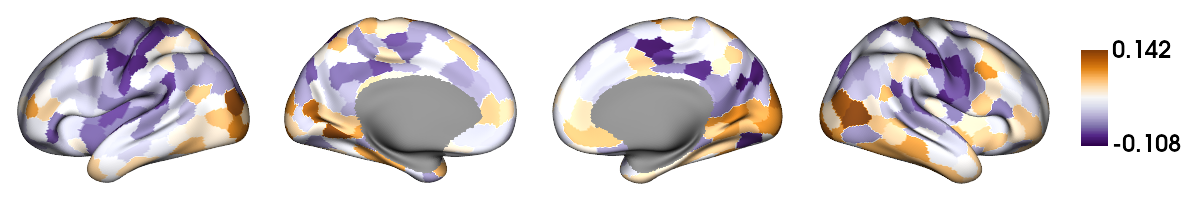

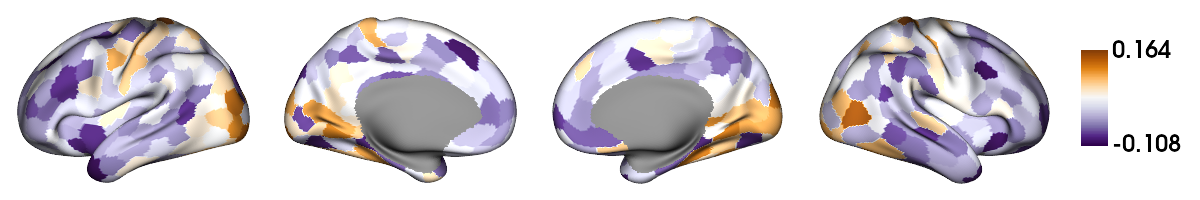

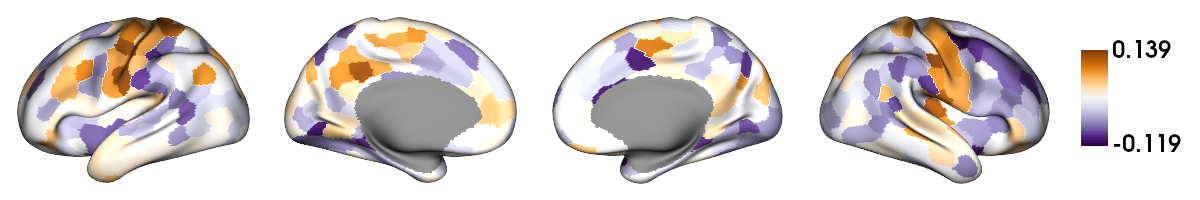


Cortical projections saved and displayed for all gradients.


In [44]:
"""
Plot cortical maps of LV1 loadings for each gradient
"""

import numpy as np
from IPython.display import Image, display
import os

# Assume you have a brain atlas called `atlas` (same dimensions as cortical map)
# e.g., atlas = nib.load('atlas.nii.gz').get_fdata()
# atlas labels nodes from 1 to 400

# Create directory for figures
os.makedirs("new_figures", exist_ok=True)

# Loop over gradients
for grad_name_proj, grad_res_proj in results_pls.items():

    X_weights_proj = grad_res_proj['X_weights']  # LV1 only

    # Initialize brain map with NaNs
    brain_map_proj = np.full_like(atlas, np.nan, dtype=float)

    # Fill in parcels
    for idx in range(len(X_weights_proj)):
        brain_map_proj[atlas == idx + 1] = X_weights_proj[idx]
    brain_map_proj[atlas == 0] = np.nan

    # Save filename
    filename_proj = f'new_figures/{grad_name_proj}_LV1_cortical_map.png'

    # Plot cortical surface using your custom function (replace `fp.plot_surface`)
    fp.plot_surface(
        data=[brain_map_proj],
        size=(1200, 200),
        cmap='PuOr_r',
        display=False,
        filename=filename_proj
    )

    # Display saved image
    display(Image(filename_proj))

print("\nCortical projections saved and displayed for all gradients.")


## Permutation testing

In [45]:
"""
Permutation testing for LV1 of each gradient
"""

import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Parameters
# -------------------------------
n_permutations_perm = 10000  # number of permutations
n_components_perm = 1        # LV1 only
results_perm_test = {}       # store permutation p-values

# Loop over gradients
for grad_name_perm, grad_res_perm in results_pls.items():
    print(f"\nPermutation testing for {grad_name_perm}...")

    X_std_perm = grad_res_perm['X_std']  # standardized brain features
    Y_std_perm = grad_res_perm['Y_std']  # standardized behavioral variables (including age and gender)

    # Fit original PLS to get observed covariance
    pls_orig_perm = PLSRegression(n_components=n_components_perm)
    pls_orig_perm.fit(X_std_perm, Y_std_perm)

    X_scores_obs = pls_orig_perm.x_scores_[:, 0]
    Y_scores_obs = pls_orig_perm.y_scores_[:, 0]

    obs_cov_perm = np.cov(X_scores_obs, Y_scores_obs, bias=True)[0, 1]

    # -------------------------------
    # Run permutations
    # -------------------------------
    perm_covs = np.zeros(n_permutations_perm)

    for i_perm in range(n_permutations_perm):
        X_perm_shuffled = X_std_perm[np.random.permutation(X_std_perm.shape[0]), :]
        pls_perm = PLSRegression(n_components=n_components_perm)
        pls_perm.fit(X_perm_shuffled, Y_std_perm)
        X_scores_perm = pls_perm.x_scores_[:, 0]
        Y_scores_perm = pls_perm.y_scores_[:, 0]
        perm_covs[i_perm] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # p-value: proportion of permuted covariances >= observed
    p_value_perm = np.mean(perm_covs >= obs_cov_perm)

    results_perm_test[grad_name_perm] = {
        'obs_cov': obs_cov_perm,
        'perm_covs': perm_covs,
        'p_value': p_value_perm
    }

    print(f"{grad_name_perm} LV1 permutation p-value: {p_value_perm:.4f}")



Permutation testing for G1...
G1 LV1 permutation p-value: 0.0286

Permutation testing for G2...
G2 LV1 permutation p-value: 0.1230

Permutation testing for G3...
G3 LV1 permutation p-value: 0.1157


## Bootstrap resampling


Bootstrap resampling for G1...


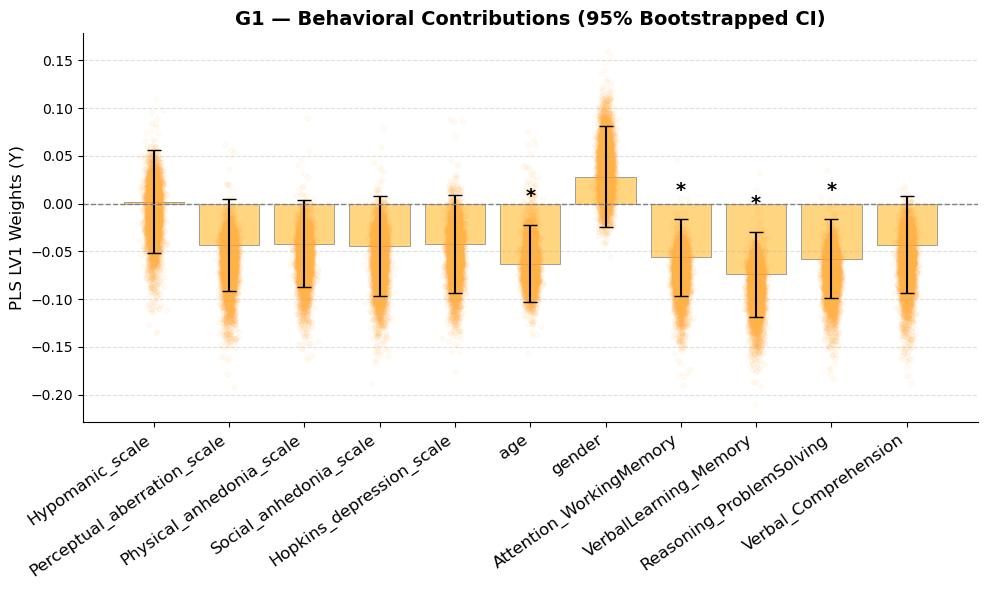


Bootstrap resampling for G2...


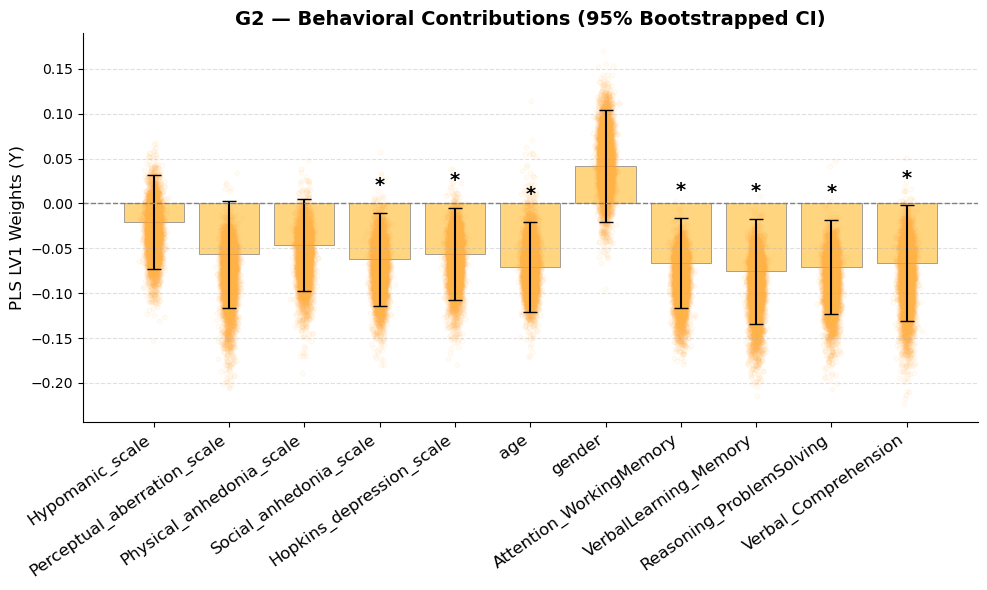


Bootstrap resampling for G3...


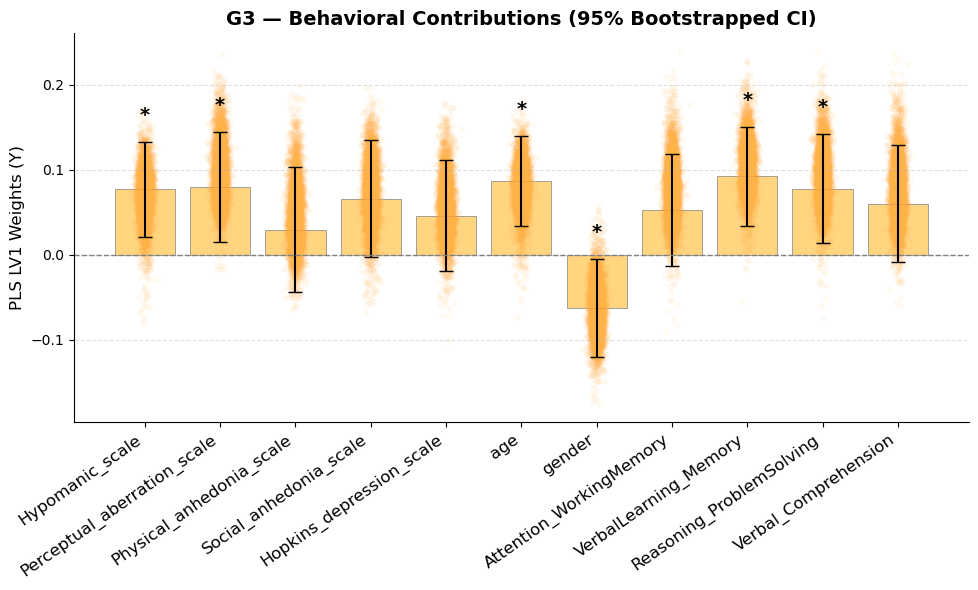

In [46]:
"""
Bootstrap resampling for LV1 of each gradient
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils import resample

# -------------------------------
# Parameters
# -------------------------------
n_bootstrap_resample = 5000  # number of bootstrap resamples
n_components_boot = 1         # LV1 only
results_boot_test = {}        # store bootstrap ratios

# Plot settings
bar_color_boot = '#FFD580'
point_color_boot = '#FFB347'
star_color_boot = 'black'

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name_boot, grad_res_boot in results_pls.items():
    print(f"\nBootstrap resampling for {grad_name_boot}...")

    X_std_boot = grad_res_boot['X_std']
    Y_std_boot = grad_res_boot['Y_std']
    n_subjects_boot, n_voxels_boot = X_std_boot.shape
    n_behav_boot = Y_std_boot.shape[1]

    # Original PLS weights
    pls_orig_boot = PLSRegression(n_components=n_components_boot)
    pls_orig_boot.fit(X_std_boot, Y_std_boot)
    X_weights_orig_boot = pls_orig_boot.x_weights_[:, 0]
    Y_weights_orig_boot = pls_orig_boot.y_weights_[:, 0]

    # -------------------------------
    # Bootstrap resampling
    # -------------------------------
    X_boot_weights_all = np.zeros((n_bootstrap_resample, n_voxels_boot))
    Y_boot_weights_all = np.zeros((n_bootstrap_resample, n_behav_boot))

    for i_boot in range(n_bootstrap_resample):
        # Resample subjects with replacement
        Xb, Yb = resample(X_std_boot, Y_std_boot, n_samples=n_subjects_boot, replace=True)

        pls_boot = PLSRegression(n_components=n_components_boot)
        pls_boot.fit(Xb, Yb)
        Xb_weights = pls_boot.x_weights_[:, 0]
        Yb_weights = pls_boot.y_weights_[:, 0]

        # Align sign with original LV1
        if np.dot(Xb_weights, X_weights_orig_boot) < 0:
            Xb_weights *= -1
            Yb_weights *= -1

        X_boot_weights_all[i_boot, :] = Xb_weights
        Y_boot_weights_all[i_boot, :] = Yb_weights

    # Compute bootstrap ratios
    X_bsr_boot = X_weights_orig_boot / X_boot_weights_all.std(axis=0)
    Y_bsr_boot = Y_weights_orig_boot / Y_boot_weights_all.std(axis=0)

    # Save results
    results_boot_test[grad_name_boot] = {
        'X_bsr': X_bsr_boot,
        'Y_bsr': Y_bsr_boot,
        'X_boot_weights': X_boot_weights_all,
        'Y_boot_weights': Y_boot_weights_all
    }

    # -------------------------------
    # Behavioral bar plot
    # -------------------------------
    Y_cols_boot = list(grad_res_boot['behav_corrs'].keys())
    y_mean_boot = Y_weights_orig_boot
    y_sd_boot = Y_boot_weights_all.std(axis=0)
    lower_ci_boot = y_mean_boot - 1.96 * y_sd_boot
    upper_ci_boot = y_mean_boot + 1.96 * y_sd_boot
    significant_boot = (lower_ci_boot > 0) | (upper_ci_boot < 0)

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(np.arange(n_behav_boot), y_mean_boot,
                  width=0.8,
                  yerr=[y_mean_boot - lower_ci_boot, upper_ci_boot - y_mean_boot],
                  capsize=5, color=bar_color_boot, edgecolor='gray', linewidth=0.5)

    # Overlay bootstrap points
    for j in range(n_behav_boot):
        x_jitter = np.random.normal(j, 0.05, size=n_bootstrap_resample)
        ax.scatter(x_jitter, Y_boot_weights_all[:, j], color=point_color_boot, alpha=0.05, s=12)

    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Significance stars
    for j, sig in enumerate(significant_boot):
        if sig:
            ax.text(j, upper_ci_boot[j] + 0.02, "*", ha='center', va='bottom', fontsize=14,
                    color=star_color_boot, fontweight='bold')

    # Labels
    ax.set_xticks(np.arange(n_behav_boot))
    ax.set_xticklabels(Y_cols_boot, rotation=35, ha='right', fontsize=12)
    ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
    ax.set_title(f'{grad_name_boot} — Behavioral Contributions (95% Bootstrapped CI)', fontsize=14, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.show()


## Variance explained


Computing variance explained for G1...
  LV1 explains 8.53% of X variance, 5.39% of Y variance, and 11.79% shared variance.

Computing variance explained for G2...
  LV1 explains 7.31% of X variance, 5.99% of Y variance, and 6.50% shared variance.

Computing variance explained for G3...
  LV1 explains 6.52% of X variance, 7.22% of Y variance, and 5.28% shared variance.


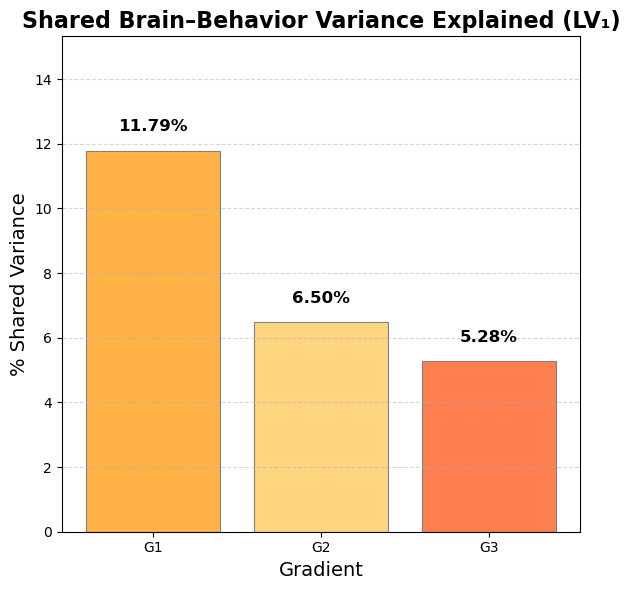


✅ Variance explained analysis complete. Results stored in `var_explained_dict_new`.


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

# -------------------------------------
# Create output folder if not exists
# -------------------------------------
os.makedirs("new_figures", exist_ok=True)

# -------------------------------------
# Variance explained dictionary
# -------------------------------------
var_explained_dict_new = {}

for grad_name_new, res_new in results_pls.items():
    print(f"\nComputing variance explained for {grad_name_new}...")

    X_std_new = res_new['X_std']  # standardized brain data
    Y_std_new = res_new['Y_std']  # standardized behavioral data including age/gender

    pls_new = PLSRegression(n_components=1)
    pls_new.fit(X_std_new, Y_std_new)

    # ----------------------------
    # Reconstruct predicted X and Y
    # ----------------------------
    X_pred_new = pls_new.x_scores_ @ pls_new.x_loadings_.T
    Y_pred_new = pls_new.x_scores_ @ pls_new.y_loadings_.T

    # ----------------------------
    # Compute variance explained
    # ----------------------------
    var_X_total_new = np.var(X_std_new, axis=0).sum()
    var_Y_total_new = np.var(Y_std_new, axis=0).sum()

    var_X_expl_new = np.var(X_pred_new, axis=0).sum() / var_X_total_new
    var_Y_expl_new = np.var(Y_pred_new, axis=0).sum() / var_Y_total_new

    # Shared cross-covariance variance (singular value-based)
    shared_var_new = (pls_new.x_scores_.T @ pls_new.y_scores_)**2 / (np.sum(X_std_new**2) * np.sum(Y_std_new**2))
    shared_var_new = shared_var_new.item()

    # Store results in both master dict and inside the results
    res_new['var_X_expl'] = var_X_expl_new
    res_new['var_Y_expl'] = var_Y_expl_new
    res_new['shared_var'] = shared_var_new

    var_explained_dict_new[grad_name_new] = {
        'X_var%': var_X_expl_new * 100,
        'Y_var%': var_Y_expl_new * 100,
        'Shared%': shared_var_new * 100
    }

    print(f"  LV1 explains {var_X_expl_new * 100:.2f}% of X variance, "
          f"{var_Y_expl_new * 100:.2f}% of Y variance, "
          f"and {shared_var_new * 100:.2f}% shared variance.")

# -------------------------------------
# Plot shared variance explained
# -------------------------------------
grad_names_new = list(var_explained_dict_new.keys())
shared_vals_new = [v['Shared%'] for v in var_explained_dict_new.values()]

plt.figure(figsize=(6, 6))
bars = plt.bar(grad_names_new, shared_vals_new,
               color=['#FFB347', '#FFD580', '#FF7F50'],
               edgecolor='gray', linewidth=0.8)

# Annotate each bar
for i, v in enumerate(shared_vals_new):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom',
             fontsize=12, fontweight='bold')

plt.title("Shared Brain–Behavior Variance Explained (LV₁)",
          fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.xlabel("Gradient", fontsize=14)
plt.ylim(0, max(shared_vals_new) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1_new.png", dpi=300)
plt.show()

print("\n✅ Variance explained analysis complete. Results stored in `var_explained_dict_new`.")


## New variance explained

Computing variance explained for gradient-based PLS (age & gender included)...

G1:
  LV1 explains 8.53% of X variance, 5.39% of Y variance, 67.62% of total X–Y cross-covariance energy, and latent t–u r² = 19.03%

G2:
  LV1 explains 7.31% of X variance, 5.99% of Y variance, 70.31% of total X–Y cross-covariance energy, and latent t–u r² = 20.46%

G3:
  LV1 explains 6.52% of X variance, 7.22% of Y variance, 68.61% of total X–Y cross-covariance energy, and latent t–u r² = 26.24%



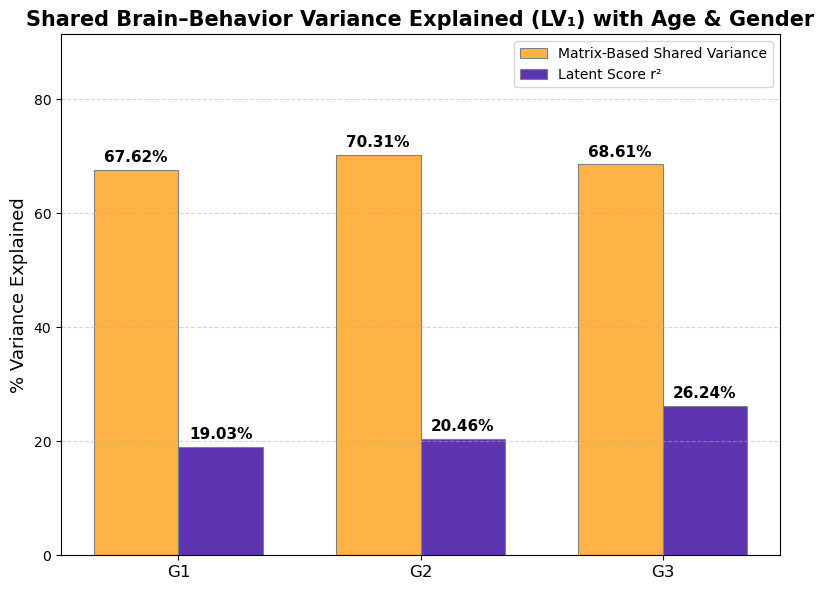


✅ Variance explained analysis complete. Results stored in `var_explained_dict_new2`.


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

# -------------------------------------
# Create output folder if not exists
# -------------------------------------
os.makedirs("new_figures", exist_ok=True)

# -------------------------------------
# Initialize dictionary
# -------------------------------------
var_explained_dict_new2 = {}

print("Computing variance explained for gradient-based PLS (age & gender included)...\n")

# -------------------------------------
# Loop through all gradient-based PLS
# -------------------------------------
for grad_name_new2, res_new2 in results_pls.items():

    X_std_new2 = res_new2['X_std']  # standardized brain data
    Y_std_new2 = res_new2['Y_std']  # standardized behavioral data including age/gender
    n_samples_new2 = X_std_new2.shape[0]

    pls_new2 = PLSRegression(n_components=1)
    pls_new2.fit(X_std_new2, Y_std_new2)

    # ----------------------------
    # Predicted data reconstruction
    # ----------------------------
    X_pred_new2 = pls_new2.x_scores_ @ pls_new2.x_loadings_.T
    Y_pred_new2 = pls_new2.x_scores_ @ pls_new2.y_loadings_.T

    # ----------------------------
    # Variance explained (block-specific)
    # ----------------------------
    var_X_expl_new2 = np.sum(X_pred_new2**2) / np.sum(X_std_new2**2)
    var_Y_expl_new2 = np.sum(Y_pred_new2**2) / np.sum(Y_std_new2**2)

    # -------------------------------------
    # Shared variance (matrix-based approach)
    # -------------------------------------
    C_full_new2 = (X_std_new2.T @ Y_std_new2) / (n_samples_new2 - 1)
    C_pred_new2 = (X_pred_new2.T @ Y_pred_new2) / (n_samples_new2 - 1)

    total_cross_energy_new2 = np.sum(C_full_new2**2)
    explained_cross_energy_new2 = np.sum(C_pred_new2**2)
    shared_var_matrix_new2 = 0.0 if total_cross_energy_new2 == 0 else explained_cross_energy_new2 / total_cross_energy_new2

    # -------------------------------------
    # Latent score correlation (r²)
    # -------------------------------------
    t_new2 = pls_new2.x_scores_[:, 0]
    u_new2 = pls_new2.y_scores_[:, 0]
    r2_latent_new2 = np.corrcoef(t_new2, u_new2)[0, 1] ** 2

    # -------------------------------------
    # Store results
    # -------------------------------------
    res_new2['var_X_expl'] = var_X_expl_new2
    res_new2['var_Y_expl'] = var_Y_expl_new2
    res_new2['shared_var_matrix'] = shared_var_matrix_new2
    res_new2['r2_latent'] = r2_latent_new2

    var_explained_dict_new2[grad_name_new2] = {
        'X_var%': var_X_expl_new2 * 100,
        'Y_var%': var_Y_expl_new2 * 100,
        'Shared_matrix%': shared_var_matrix_new2 * 100,
        'r2_latent%': r2_latent_new2 * 100
    }

    print(f"{grad_name_new2}:")
    print(f"  LV1 explains {var_X_expl_new2 * 100:.2f}% of X variance, "
          f"{var_Y_expl_new2 * 100:.2f}% of Y variance, "
          f"{shared_var_matrix_new2 * 100:.2f}% of total X–Y cross-covariance energy, "
          f"and latent t–u r² = {r2_latent_new2 * 100:.2f}%\n")

# -------------------------------------
# Combined bar plot (Matrix vs Latent r²)
# -------------------------------------
grad_names_new2 = list(var_explained_dict_new2.keys())
matrix_vals_new2 = [v['Shared_matrix%'] for v in var_explained_dict_new2.values()]
latent_vals_new2 = [v['r2_latent%'] for v in var_explained_dict_new2.values()]

x_new2 = np.arange(len(grad_names_new2))
width_new2 = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x_new2 - width_new2/2, matrix_vals_new2, width_new2,
        label='Matrix-Based Shared Variance',
        color='#FFB347', edgecolor='gray', linewidth=0.8)
plt.bar(x_new2 + width_new2/2, latent_vals_new2, width_new2,
        label='Latent Score r²',
        color='#5E35B1', edgecolor='gray', linewidth=0.8)

# Annotate values
for i in range(len(grad_names_new2)):
    plt.text(x_new2[i] - width_new2/2, matrix_vals_new2[i] + 0.8, f"{matrix_vals_new2[i]:.2f}%",
             ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x_new2[i] + width_new2/2, latent_vals_new2[i] + 0.8, f"{latent_vals_new2[i]:.2f}%",
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x_new2, grad_names_new2, fontsize=12)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared Brain–Behavior Variance Explained (LV₁) with Age & Gender",
          fontsize=15, fontweight='bold')
plt.ylim(0, max(max(matrix_vals_new2), max(latent_vals_new2)) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_LV1_new.png", dpi=300)
plt.show()

print("\n✅ Variance explained analysis complete. Results stored in `var_explained_dict_new2`.")


## Cross validation


Cross-validating G1...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.226


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  → Cross-validated correlation p-value = 0.0120

Cross-validating G2...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.138
  → Cross-validated correlation p-value = 0.0900

Cross-validating G3...
  Using 5-fold CV with 20 repeats.
  Observed out-of-sample correlation: r = 0.248
  → Cross-validated correlation p-value = 0.0100


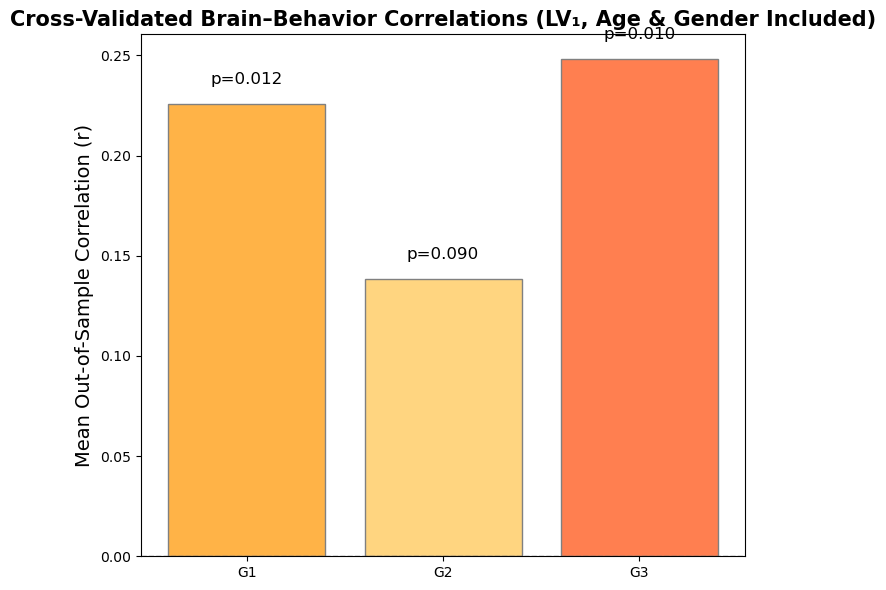


✅ Cross-validation analysis complete. Results stored in `cv_results_new7`.


In [50]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, LeaveOneOut
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --------------------------------------------------
# PARAMETERS
# --------------------------------------------------
n_splits_new7 = 5        # KFold splits for larger samples
n_repeats_new7 = 20      # number of random splits for KFold
n_perm_new7 = 1000       # number of permutations
random_state_new7 = 42

cv_results_new7 = {}

# --------------------------------------------------
# CROSS-VALIDATION LOOP
# --------------------------------------------------
for grad_name_new7, res_new7 in results_pls.items():
    print(f"\nCross-validating {grad_name_new7}...")

    X_new7 = res_new7['X_std']  # standardized brain data
    Y_new7 = res_new7['Y_std']  # standardized behavioral + age/gender data
    n_new7 = X_new7.shape[0]

    # Determine CV strategy
    if n_new7 < 80:
        print(f"  Small sample detected (n={n_new7}) → using Leave-One-Out CV.")
        use_loocv_new7 = True
        n_repeats_eff_new7 = 1
    else:
        print(f"  Using {n_splits_new7}-fold CV with {n_repeats_new7} repeats.")
        use_loocv_new7 = False
        n_repeats_eff_new7 = n_repeats_new7

    # ---------------------------
    # Collect predicted scores
    # ---------------------------
    all_x_pred_new7 = np.zeros(n_new7)
    all_y_pred_new7 = np.zeros(n_new7)

    if use_loocv_new7:
        # LOOCV
        for test_idx_new7 in range(n_new7):
            train_idx_new7 = np.setdiff1d(np.arange(n_new7), test_idx_new7)
            pls_cv_new7 = PLSRegression(n_components=1)
            pls_cv_new7.fit(X_new7[train_idx_new7], Y_new7[train_idx_new7])

            all_x_pred_new7[test_idx_new7] = X_new7[test_idx_new7] @ pls_cv_new7.x_weights_[:, 0]
            all_y_pred_new7[test_idx_new7] = Y_new7[test_idx_new7] @ pls_cv_new7.y_weights_[:, 0]
    else:
        # KFold repeated CV
        temp_x_pred_new7 = np.zeros((n_repeats_eff_new7, n_new7))
        temp_y_pred_new7 = np.zeros((n_repeats_eff_new7, n_new7))

        for rep_new7 in range(n_repeats_eff_new7):
            kf_new7 = KFold(n_splits=n_splits_new7, shuffle=True, random_state=random_state_new7 + rep_new7)
            for train_idx_new7, test_idx_new7 in kf_new7.split(X_new7):
                pls_cv_new7 = PLSRegression(n_components=1)
                pls_cv_new7.fit(X_new7[train_idx_new7], Y_new7[train_idx_new7])
                temp_x_pred_new7[rep_new7, test_idx_new7] = X_new7[test_idx_new7] @ pls_cv_new7.x_weights_[:, 0]
                temp_y_pred_new7[rep_new7, test_idx_new7] = Y_new7[test_idx_new7] @ pls_cv_new7.y_weights_[:, 0]
        # Average across repeats
        all_x_pred_new7 = temp_x_pred_new7.mean(axis=0)
        all_y_pred_new7 = temp_y_pred_new7.mean(axis=0)

    # ---------------------------
    # Compute observed correlation
    # ---------------------------
    observed_r_new7, _ = pearsonr(all_x_pred_new7, all_y_pred_new7)
    print(f"  Observed out-of-sample correlation: r = {observed_r_new7:.3f}")

    # ---------------------------
    # Permutation testing
    # ---------------------------
    perm_corrs_new7 = []
    for perm_new7 in range(n_perm_new7):
        Y_perm_new7 = Y_new7[np.random.permutation(n_new7)]

        if use_loocv_new7:
            perm_x_pred_new7 = np.zeros(n_new7)
            perm_y_pred_new7 = np.zeros(n_new7)
            for test_idx_new7 in range(n_new7):
                train_idx_new7 = np.setdiff1d(np.arange(n_new7), test_idx_new7)
                pls_perm_new7 = PLSRegression(n_components=1)
                pls_perm_new7.fit(X_new7[train_idx_new7], Y_perm_new7[train_idx_new7])
                perm_x_pred_new7[test_idx_new7] = X_new7[test_idx_new7] @ pls_perm_new7.x_weights_[:, 0]
                perm_y_pred_new7[test_idx_new7] = Y_perm_new7[test_idx_new7] @ pls_perm_new7.y_weights_[:, 0]
        else:
            temp_x_perm_new7 = np.zeros((n_repeats_eff_new7, n_new7))
            temp_y_perm_new7 = np.zeros((n_repeats_eff_new7, n_new7))
            for rep_new7 in range(n_repeats_eff_new7):
                kf_new7 = KFold(n_splits=n_splits_new7, shuffle=True, random_state=random_state_new7 + rep_new7)
                for train_idx_new7, test_idx_new7 in kf_new7.split(X_new7):
                    pls_perm_new7 = PLSRegression(n_components=1)
                    pls_perm_new7.fit(X_new7[train_idx_new7], Y_perm_new7[train_idx_new7])
                    temp_x_perm_new7[rep_new7, test_idx_new7] = X_new7[test_idx_new7] @ pls_perm_new7.x_weights_[:, 0]
                    temp_y_perm_new7[rep_new7, test_idx_new7] = Y_perm_new7[test_idx_new7] @ pls_perm_new7.y_weights_[:, 0]
            perm_x_pred_new7 = temp_x_perm_new7.mean(axis=0)
            perm_y_pred_new7 = temp_y_perm_new7.mean(axis=0)

        r_perm_new7, _ = pearsonr(perm_x_pred_new7, perm_y_pred_new7)
        perm_corrs_new7.append(r_perm_new7)

    perm_corrs_new7 = np.array(perm_corrs_new7)
    pval_new7 = np.mean(perm_corrs_new7 >= observed_r_new7)

    cv_results_new7[grad_name_new7] = {
        'observed_r': observed_r_new7,
        'perm_corrs': perm_corrs_new7,
        'pval': pval_new7
    }

    print(f"  → Cross-validated correlation p-value = {pval_new7:.4f}")

# --------------------------------------------------
# PLOT RESULTS
# --------------------------------------------------
plt.figure(figsize=(7, 6))
bars = plt.bar(cv_results_new7.keys(),
               [cv_results_new7[g]['observed_r'] for g in cv_results_new7],
               color=['#FFB347', '#FFD580', '#FF7F50'],
               edgecolor='gray')
plt.ylabel("Mean Out-of-Sample Correlation (r)", fontsize=14)
plt.title("Cross-Validated Brain–Behavior Correlations (LV₁, Age & Gender Included)", fontsize=15, fontweight='bold')

for i, g in enumerate(cv_results_new7.keys()):
    r_val = cv_results_new7[g]['observed_r']
    p_val = cv_results_new7[g]['pval']
    plt.text(i, r_val + 0.01, f"p={p_val:.3f}", ha='center', fontsize=12)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig("new_figures/cv_out_of_sample_correlations_new7.png", dpi=300)
plt.show()

print("\n✅ Cross-validation analysis complete. Results stored in `cv_results_new7`.")


## Split half resampling

In [51]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

n_splits_new8 = 100  # number of random split-half resamplings
stability_results_new8 = {}

for grad_name_new8, res_new8 in results_pls.items():
    print(f"\nSplit-half resampling for {grad_name_new8}...")

    X_new8 = res_new8['X_std']  # standardized brain data
    Y_new8 = res_new8['Y_std']  # standardized behavioral + age/gender data
    n_new8 = X_new8.shape[0]

    brain_corrs_new8 = []
    behav_corrs_new8 = []

    for split_new8 in range(n_splits_new8):
        # Random split
        idx_new8 = np.random.permutation(n_new8)
        half_new8 = n_new8 // 2
        idx1_new8, idx2_new8 = idx_new8[:half_new8], idx_new8[half_new8:]

        # PLS on first half
        pls1_new8 = PLSRegression(n_components=1)
        pls1_new8.fit(X_new8[idx1_new8], Y_new8[idx1_new8])
        U1_new8 = pls1_new8.x_weights_[:, 0]
        V1_new8 = pls1_new8.y_weights_[:, 0]

        # PLS on second half
        pls2_new8 = PLSRegression(n_components=1)
        pls2_new8.fit(X_new8[idx2_new8], Y_new8[idx2_new8])
        U2_new8 = pls2_new8.x_weights_[:, 0]
        V2_new8 = pls2_new8.y_weights_[:, 0]

        # Align signs
        if np.dot(U1_new8, U2_new8) < 0:
            U2_new8 *= -1
            V2_new8 *= -1

        # Compute correlations
        brain_corrs_new8.append(np.corrcoef(U1_new8, U2_new8)[0, 1])
        behav_corrs_new8.append(np.corrcoef(V1_new8, V2_new8)[0, 1])

    # Store results
    stability_results_new8[grad_name_new8] = {
        'brain_stability': np.mean(brain_corrs_new8),
        'behav_stability': np.mean(behav_corrs_new8),
        'brain_corrs_all': brain_corrs_new8,
        'behav_corrs_all': behav_corrs_new8
    }

    print(f"  Brain pattern stability (mean r): {stability_results_new8[grad_name_new8]['brain_stability']:.3f}")
    print(f"  Behavioral pattern stability (mean r): {stability_results_new8[grad_name_new8]['behav_stability']:.3f}")

print("\n✅ Split-half resampling complete. Results stored in `stability_results_new8`.")



Split-half resampling for G1...
  Brain pattern stability (mean r): 0.323
  Behavioral pattern stability (mean r): 0.677

Split-half resampling for G2...
  Brain pattern stability (mean r): 0.244
  Behavioral pattern stability (mean r): 0.645

Split-half resampling for G3...
  Brain pattern stability (mean r): 0.287
  Behavioral pattern stability (mean r): 0.704

✅ Split-half resampling complete. Results stored in `stability_results_new8`.
